## Accumulate Local Effects (ALE) Documentation

This notebook demonstrates how to use `pymint` to compute 1D or 2D ALE and plot the results. ALE can be used to assess feature importance, feature attributions, and feature interactions. For more information on the dataset and initializing `InterpretToolkit`, see the [permutatation importance notebook](https://github.com/monte-flora/mintpy/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb). The concept and calculation of ALE is too much to cover in this notebook. We highly recommend readers to check out [Christoph Molnar's chapter on ALE](https://christophm.github.io/interpretable-ml-book/ale.html). 

In [1]:
#import sys, os 
#current_dir = os.getcwd()
#path = os.path.dirname(current_dir)
#sys.path.append(path)

In [2]:
import pymint
import plotting_config
import itertools

### Loading the training data and pre-fit models 

In [3]:
model_objs, model_names = pymint.load_models()
examples, targets = pymint.load_data()
# if any features are categorical, set the type and MintPy will calculate
# the categorical ALE. 
examples = examples.astype({'urban': 'category', 'rural':'category'})

## Computing 1D ALE

The following computes the 1D ALE curves for the features given. The arguments are as follows:
* `features`, a single feature or list of features to compute the 1D ALE for. Can also set to `'all'` to compute for all features in the dataframe. 
* `n_bootstrap`, number of bootstrap iterations to re-compute the 1D ALE to provide confidence intervals
* `subsample`, can be a float between 0-1 or an integer, which is interpreted as the percentage of examples or exact number of random samples to use, respectively. 
* `n_jobs`, number of processor to run the script on.
* `n_bins`, interger, the number of bins to compute the ALE. The bins are not evenly-spaced, but based on percentiles to ensure that a similar number of examples exist in each bin. Recommended to using 20-30 bins. However, highly skewed data may not be divisable into more than 15-20 bins. This issue is handled internally by `pymint`. 

For the ALE calculations, there is an accompanying `tqdm` bar showing the computation progress.  Since the computation are relatively quick, we find it best to compute the ALE for all features for three models up front.  

In [4]:
myInterpreter = pymint.InterpretToolkit(models=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )
all_results = myInterpreter.calc_ale(
                                 features='all',
                                 n_bootstrap=1, 
                                 subsample=1000, 
                                 n_jobs=6, 
                                 n_bins=20
                                )


 67%|██████▋   | 4/6 [00:05<00:02,  1.46s/it]Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
 83%|████████▎ | 5/6 [00:07<00:01,  1.40s/it]Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead

The results are stored as an `xarray.Dataset`. These results can be stored as compressed netcdf files using built-in functions (see load_results in InterpretToolkit). 

### Plotting 1D ALE for the top features 
To limit the scope of our analysis, we can start by plotting the ALE for the most important features. Assuming we have already run the permutation importance, we can pass those into `.get_important_vars`. If we are using multiple models, we can set `combine=True` and this function will make a single list of important predictors (removing duplicates). From this single list, we can ask for only a subset of features (`n_vars=7`). Otherwise, the function will return a dict with the model names as keys with the top features as items. 

To personalize your plots, you can pass a dict `display_feature_names`, which should map the feature names with a prettier, more interpretable name. To see our example of `display_feature_names`, look in `plotting_config.py`. Note that once you develop your own mapping dictionary, it can be used throughout the PyMint plotting suite. 

In [5]:
# Load the permutation important results from the saved pickle file
results = myInterpreter.load_results(fnames='multipass_importance_naupdc.nc',)

# We can use a bulit-in function that will extract the top predictors from all the model
# remove any duplicate features to produce a single list. In this case, we want the top 7 features
important_vars = myInterpreter.get_important_vars(results, multipass=True, n_vars=7, combine=True)

Though PyMint will attempt to automate the plotting, users do have some options to correct the plotting or customize it. For example, you can pass the `hspace` or `wspace` arguments to the various plotting scripts with PyMint to customize the space between plots (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html for more information).

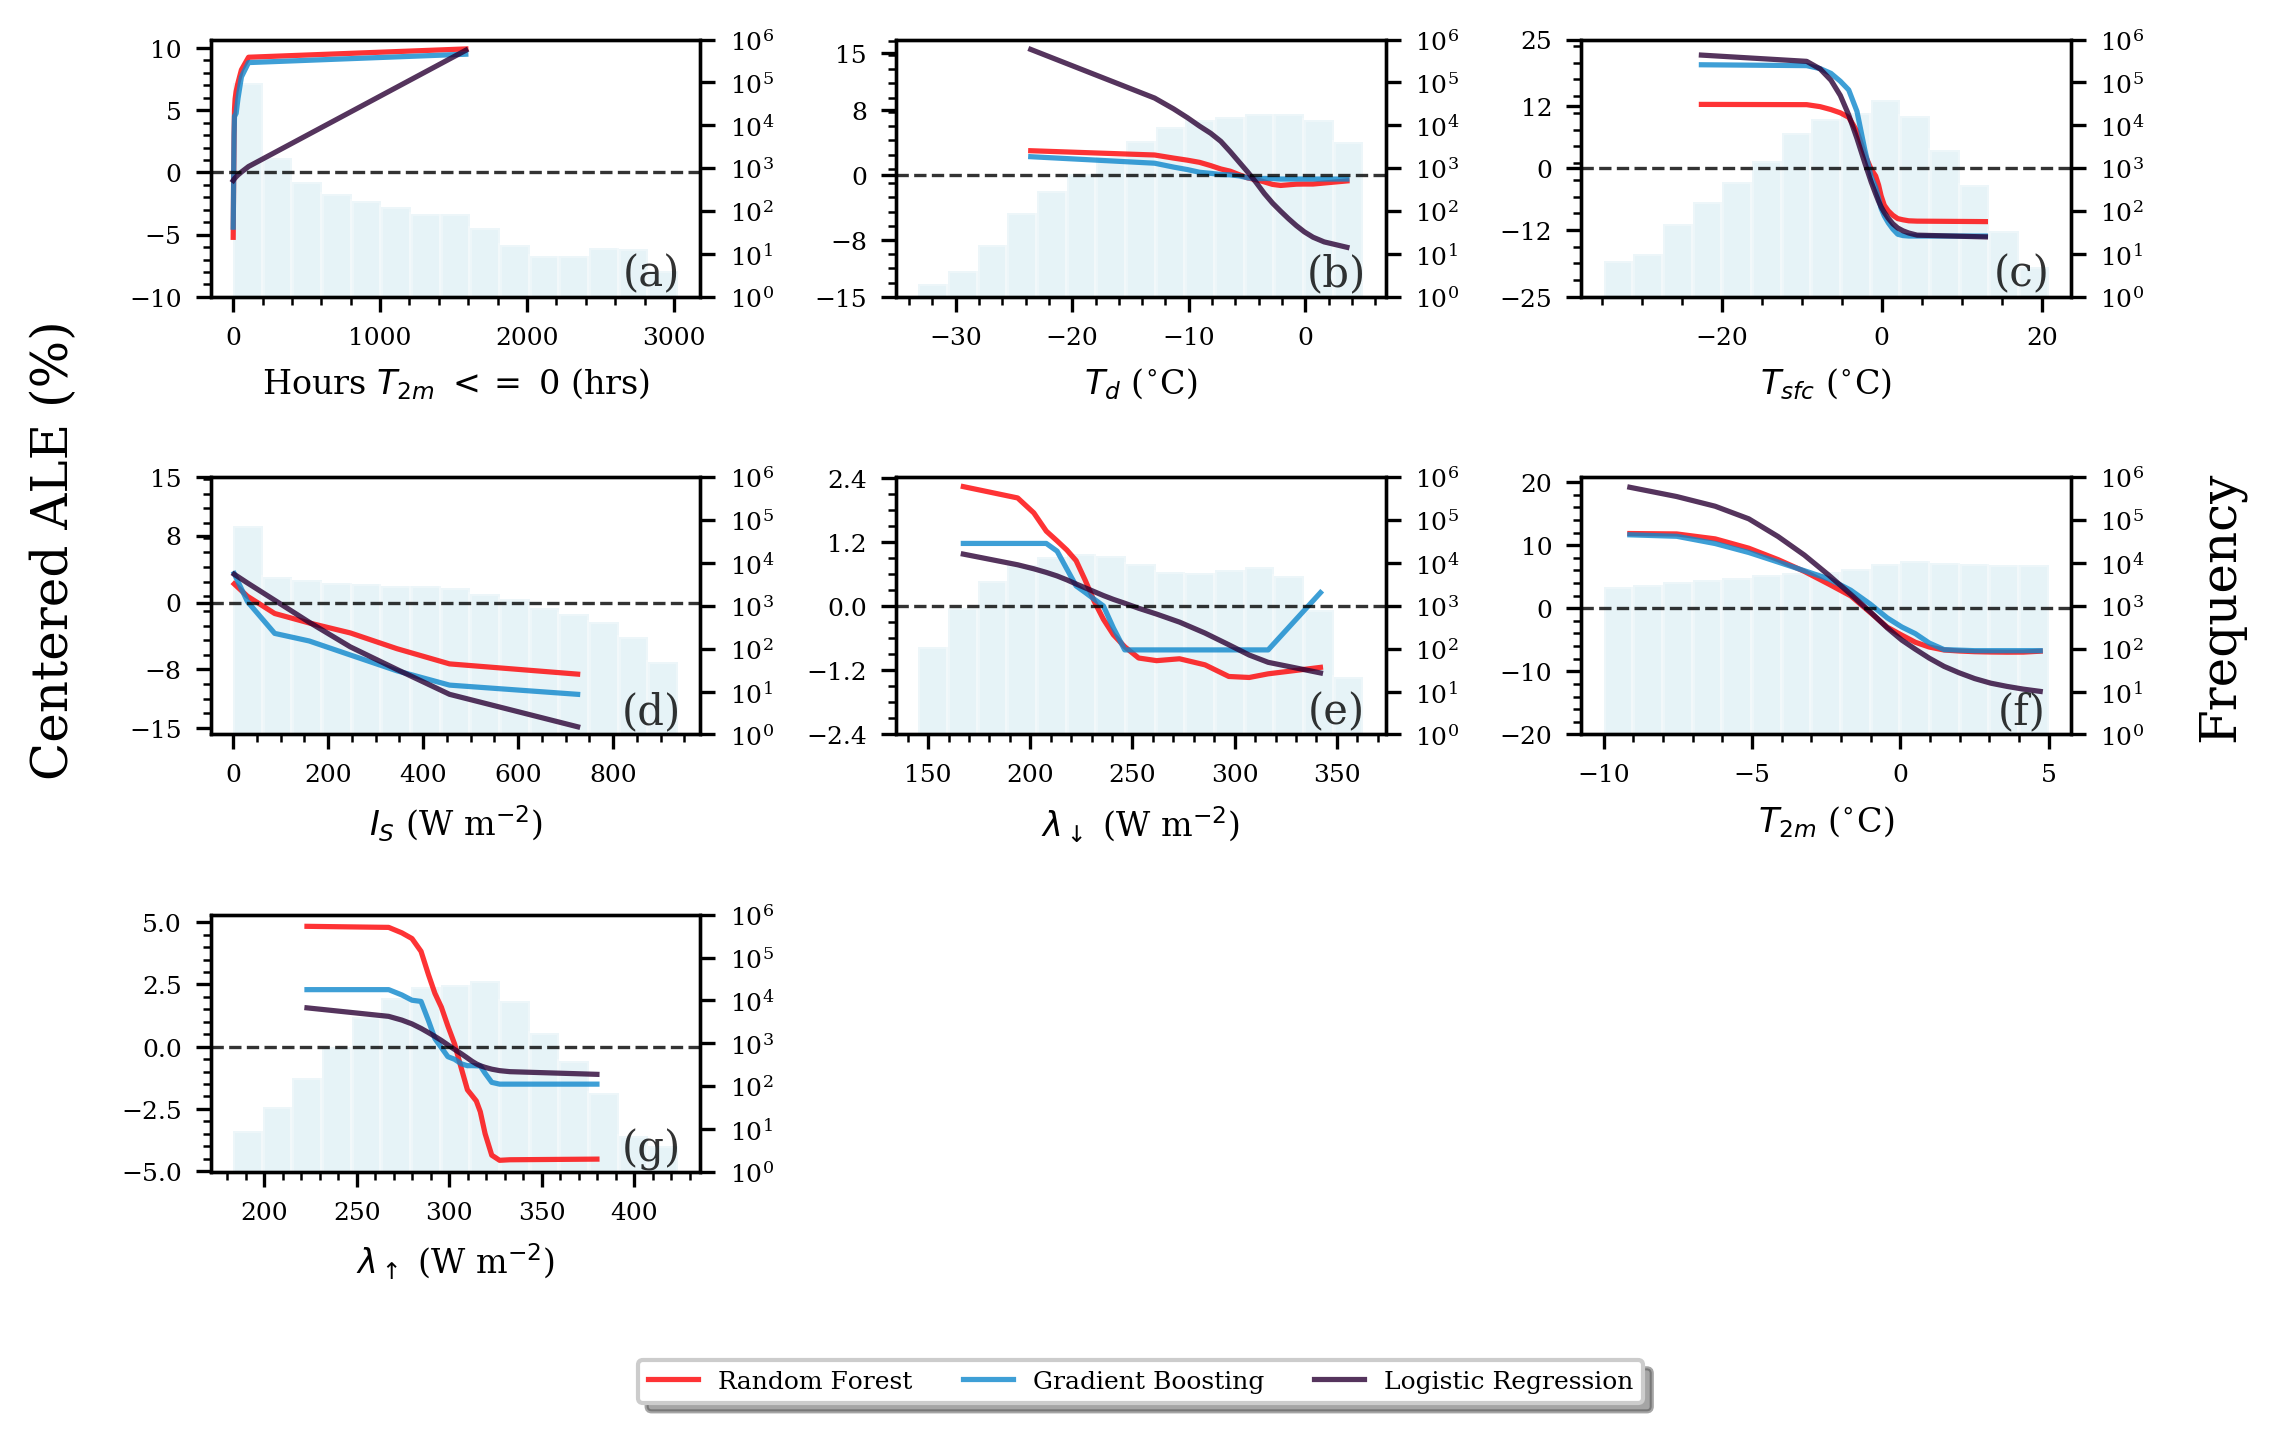

In [6]:
fig, axes = myInterpreter.plot_ale(
                                   features=important_vars,
                                   display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                   hspace=0.7
                                  )

The light blue histogram in the background is the distribution of values the ALE was computed over. In instances where the distribution is poorly sampled, we should have less confident in the ALE value. The ALE value for a particular feature value is interpreted as the expected feature contribution. For example, the generic feature attribution equation is: 
\begin{equation}
p = \mathbb{E}(f_i) + \sum_i^{N} f_i
\end{equation}
where $p$ is the prediction, $f_i$ is the contribution from the $i$-th feature (of which there are $N$), and \mathbb{E}(f_i) is typical equal to $(1/N)\sum_i^{N} f_i$. In panel (e), when the 2-m temperature ($T_{2m}$) is below 0$^{\circ}$C, the expected contribution is increasingly negative, varying between -6 to -12%, depending on the model. This is a sanity check as one would expect that cooler surface temperatures to be associated with freezing road surfaces. The large range of expected contributions from both 2-m temperature and surface temperature (panels d and e) also help explain why they were the top-most important features (see the [permutatation importance notebook](https://github.com/monte-flora/mintpy/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb) ).

### Modifying line colors 

`mintpy` has default colors, which are designed to be visually-pleasing. However, users are free to give their own colors using the `line_colors` argument. 

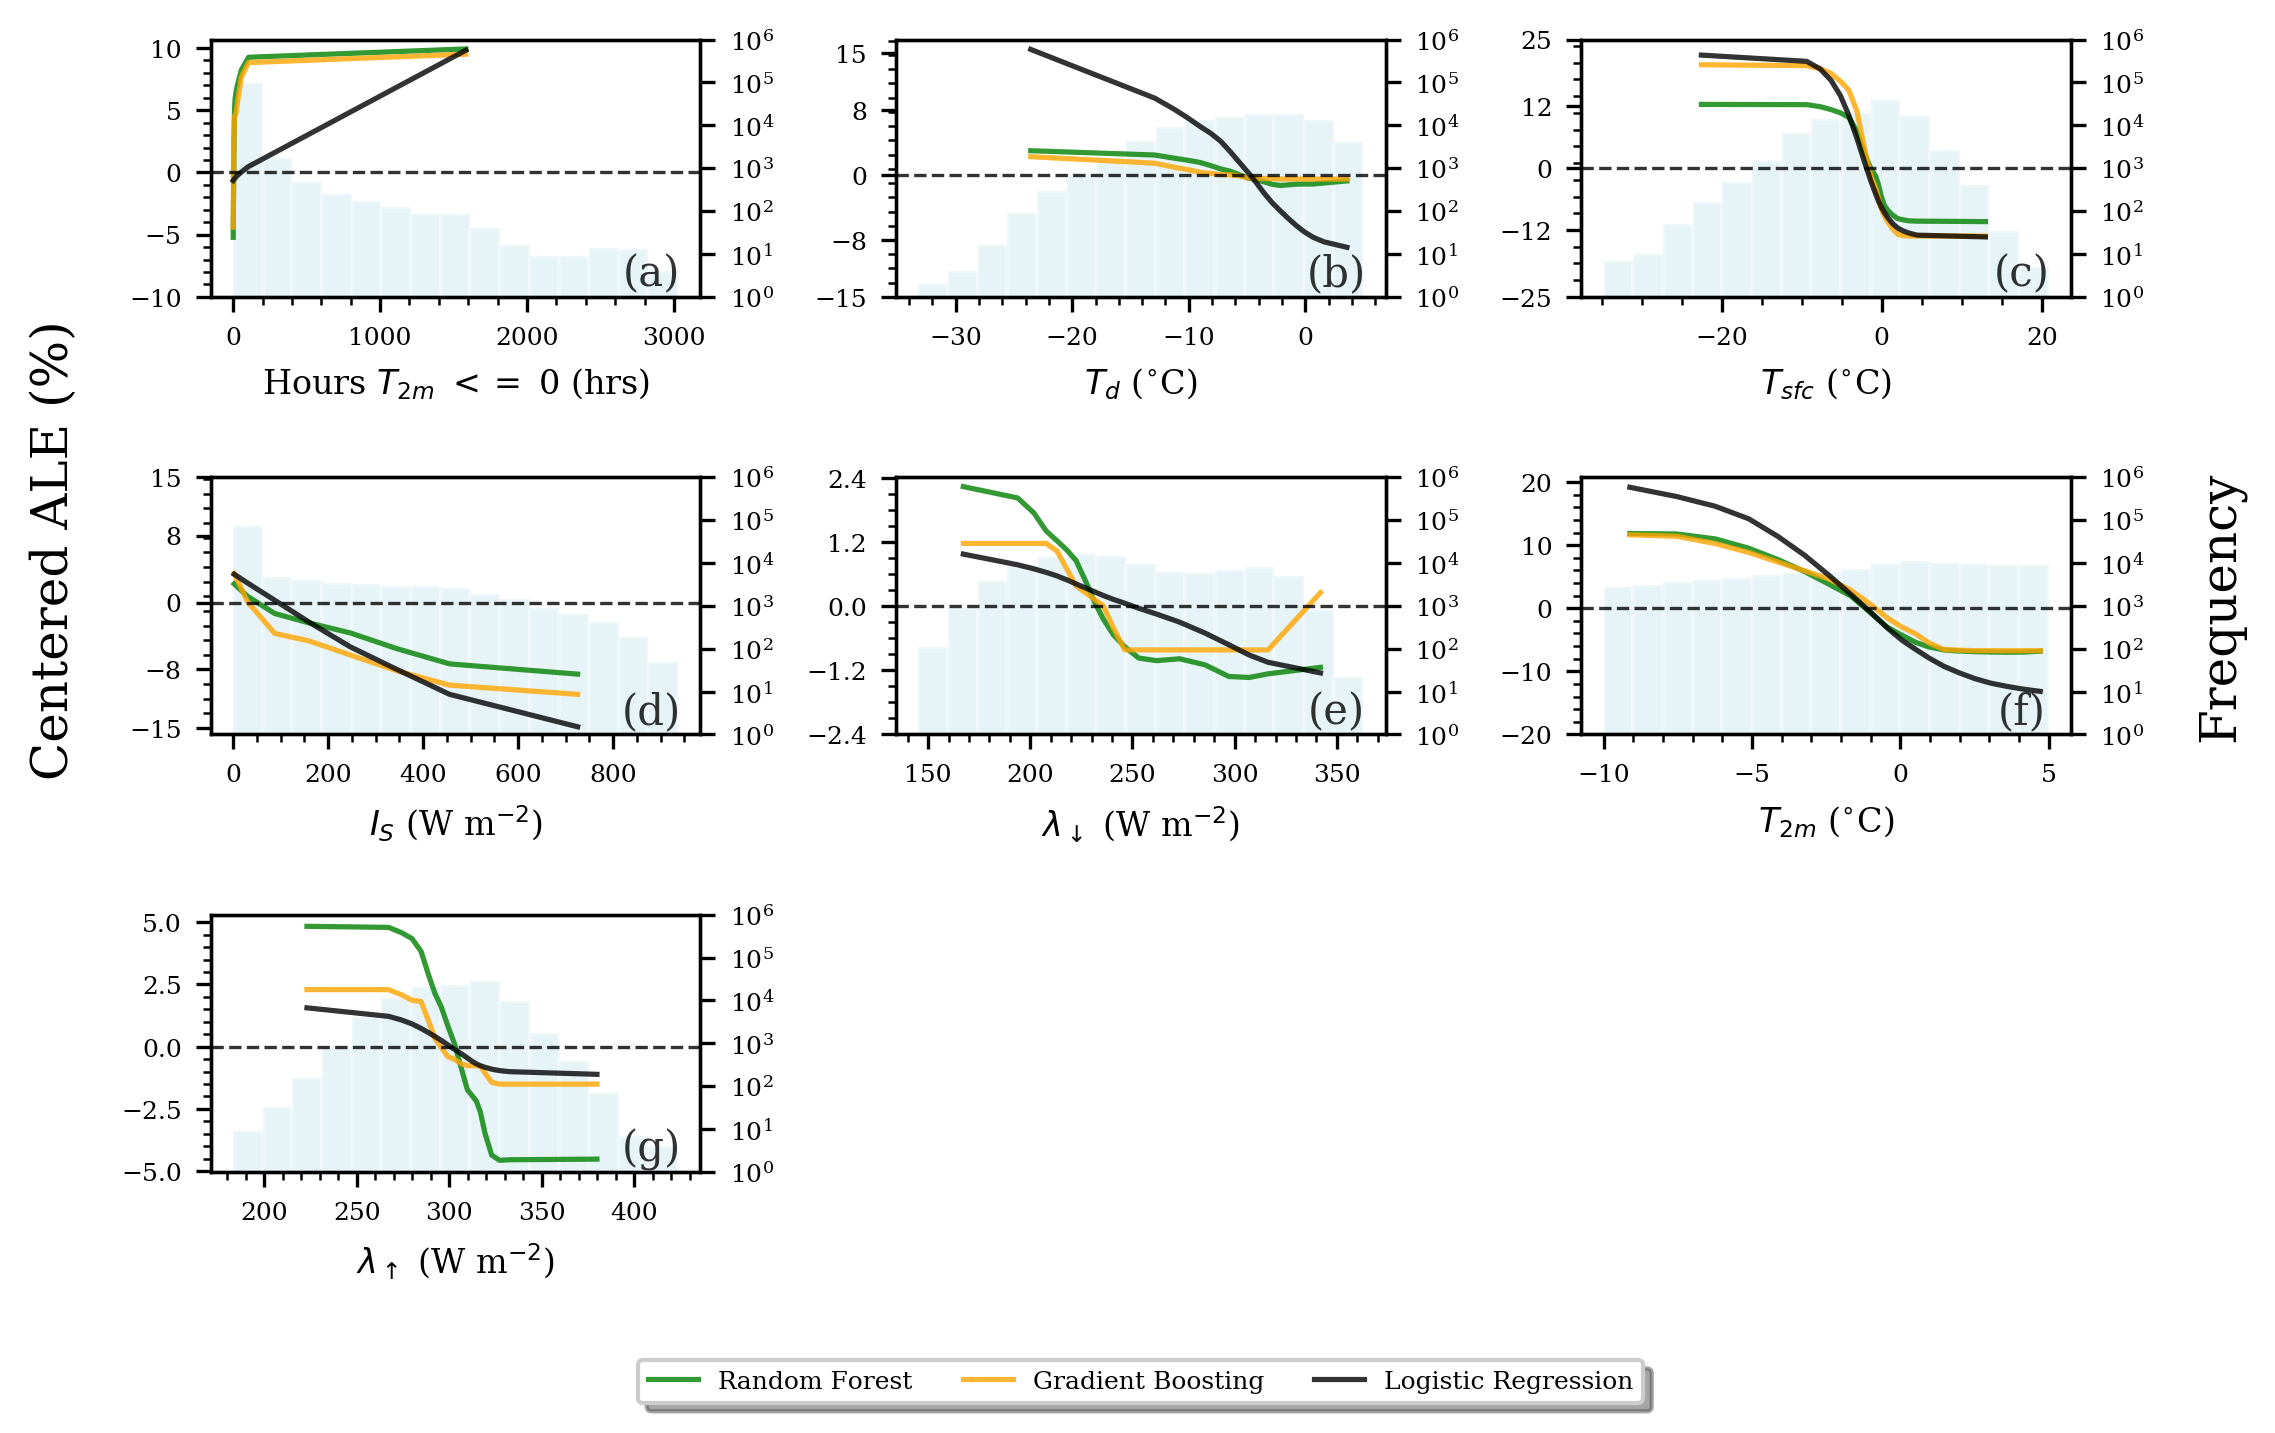

In [7]:
fig, axes = myInterpreter.plot_ale(
                                   features=important_vars,     
                                   display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                   line_colors = ['g', 'orange', 'k'],
                                   hspace=0.7
                                  )

### Including bootstrapping for confidence intervals

A crucial aspect of statistical analysis is providing uncertainty estimates. In PyMint, we use bootstrapping to provide confidence intervals for ALE. The uncertainty in ALE also carries over to other ALE-based statistics (interation strength, main effect complexity, etc.) 

100%|██████████| 21/21 [00:33<00:00,  1.59s/it]


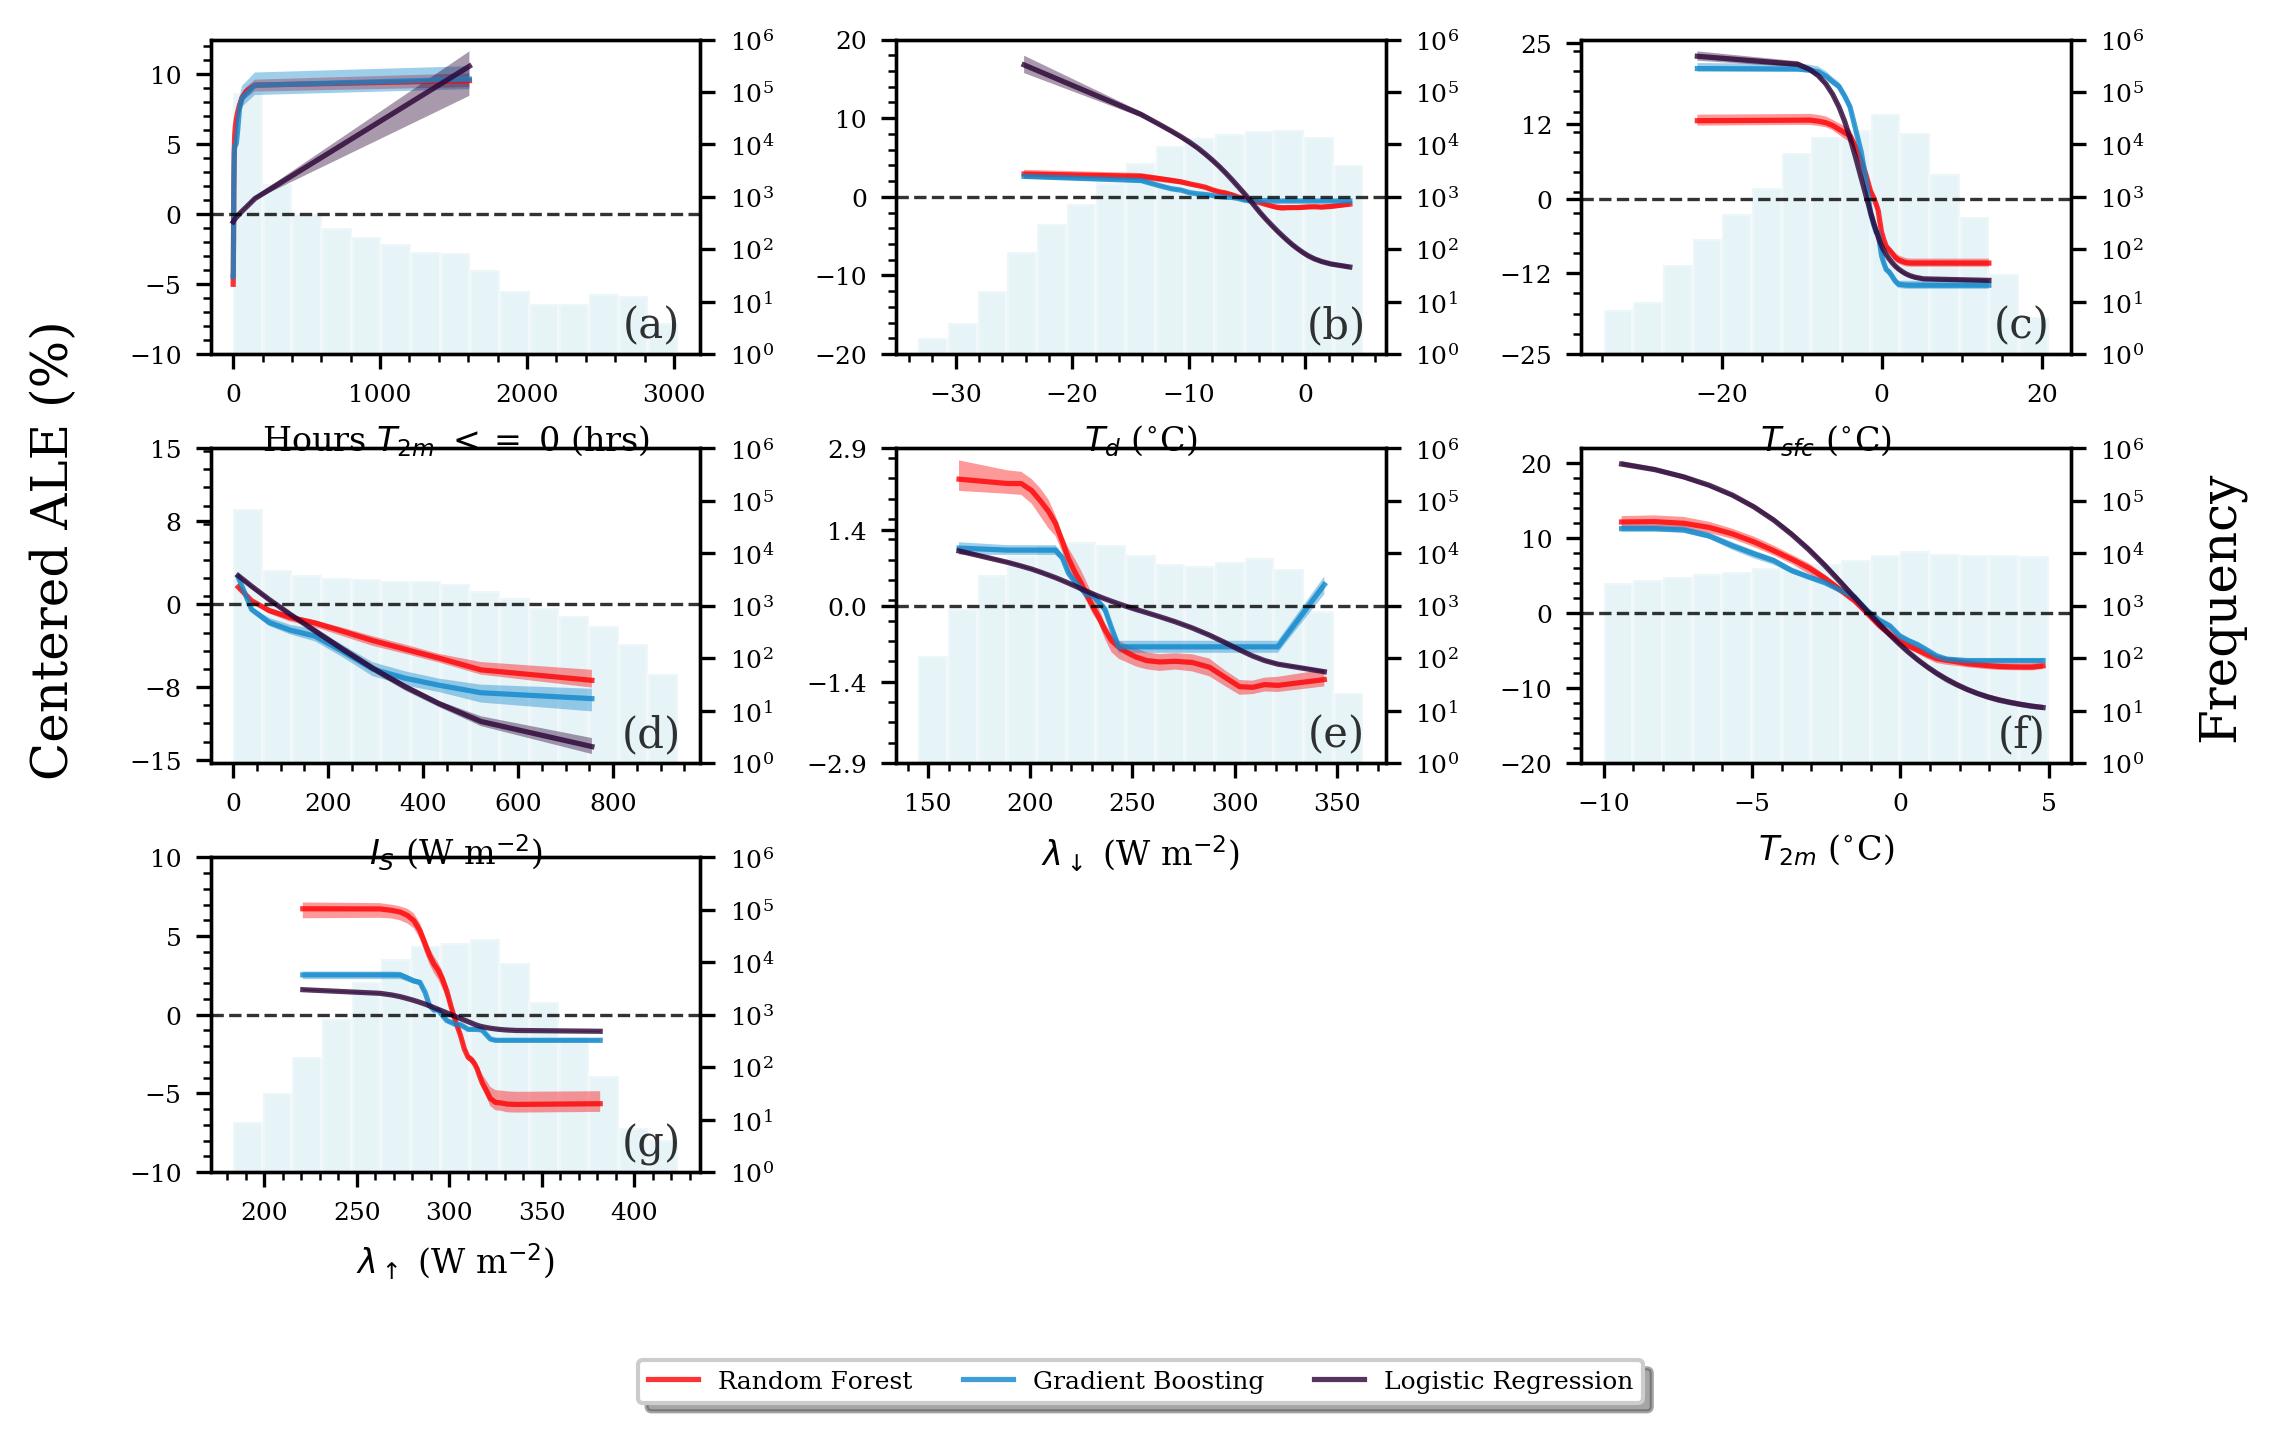

In [8]:
myInterpreter.calc_ale(features=important_vars, 
                                 n_bootstrap=10, 
                                 subsample=3000, 
                                 n_jobs=4, 
                                 n_bins=30
                                )
fig, axes = myInterpreter.plot_ale(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

Note that these confidence intervals are NOT equivalent to the uncertainty in the main effect, which is provided by the ICE curves (see next box). The confidence intervals are simply the uncertainty in the mean value. 

## Adding Individual Conditional Expectation (ICE) curves 

The ALE curves attempt to estimate the first-order or main effect of a given feature. However, if the ML model is not purely additive and contains feature interactions (e.g., $\beta x_1x_2$), then the first-order effects are often higher dimensional. However, the ALE curves is only the expected contribution (the mean value) and will require dimensionality reduction if feature interactions are present. If the reader is unaware of ICE curves, we highly recommend reading the following chapter: https://christophm.github.io/interpretable-ml-book/ice.html.

In this example, we will compute the ICE curves for only the random forest. To compute ICE curves, we call `.calc_ice`. The main argument for the ICE curves is the subsample size. Plotting more than 100-200 curves can make the plot hard to interpret, so we set the size at 200. 

In [9]:
myInterpreter = mintpy.InterpretToolkit(models=model_objs[0],
                                 model_names=model_names[0],
                                 examples=examples,
                                 targets=targets,
                                )
results = myInterpreter.calc_ale(features=important_vars, 
                                 n_bootstrap=1, 
                                 subsample=20000, 
                                 n_jobs=4, 
                                 n_bins=40
                                )

NameError: name 'mintpy' is not defined

In [ ]:
ice_results = myInterpreter.calc_ice(features=important_vars, 
                                 subsample=200, 
                                 n_jobs=4, 
                                 n_bins=30
                                )

In [ ]:
fig, axes = myInterpreter.plot_ale(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                   ice_curves=ice_results, 
                                  )

ICE curves are a permutation-based method and therefore assume feature dependence. Therefore, when we have dependent features, it can muddle our interpretation. The general idea, however, is that the spread in the ICE curves about the expected contribution indicates feature interactions. Strong feature interactions produce greater variation in the ICE curves. 

## Computing and Plotting 2D ALE 

The previous examples showed the 1D ALE curves. It is also possible to compute the ALE between two features. In this case, we are measuring the additional contribution from the combination of the two features (minus their respective 1D effects). If there is no multiplicative feature interactions between two features in a model, then the 2D ALE is zero everywhere. 

In [ ]:
features=[('temp2m', 'sfc_temp'), ('dwpt2m', 'sfc_temp'), ('temp2m', 'dwpt2m')]
myInterpreter = pymint.InterpretToolkit(models=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )
results = myInterpreter.calc_ale(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1.0,
                                 n_jobs=len(features)*len(model_names),
                                 n_bins=30
                                )

fig, axes = myInterpreter.plot_ale(display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

In these plots, 
* The marignal distribution of the two features are shown in each panel
* A subsample of the actual data is shown as dots 
* The kernal density estimate of the dots is overlaid. 

The additional overlays can be turned on or off by passing in the appropriate arguments. 

## Using ALE for feature rankings 

Though feature importance is defined with respect to model performance, we can also rank features by their magnitude of their first-order effect. Inspired by Greenwell et al. (2018, https://arxiv.org/abs/1805.04755), we can compute the standard deviation of the ALE (rather than the partial dependence) and those features with the highest standard deviation have the biggest range of contributions to a model's performance. This method has limitations though: 
* The standard deviation is affected by outliers and may skew the results. 
* When feature interactions are strong, the 1-D expected contribution may not fully capture the strength of the first-order effect.
* Only considers first-order effects
* Does not explicitly measure the contribution of features to the model's accuracy
* Unclear when the importance score is significantly/practically different from zero

In [ ]:
myInterpreter = pymint.InterpretToolkit(models=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

results = myInterpreter.calc_ale_variance(ale_data=all_results)

In [ ]:
myInterpreter.plot_importance(
                              method='ale_variance', 
                              display_feature_names=plotting_config.display_feature_names,
                              feature_colors=plotting_config.color_dict,
                              num_vars_to_plot=10 
                             )

## Using ALE for interaction effects 

We can compute the second-order ALE and then use the concept from [Greenwell et al. (2018)](https://arxiv.org/abs/1805.04755) (see Section 3.2).  In this case we are using the purely second-order ALE rather than the second-order PD. For this example, we will compute the second-ALE for every combination of the most important predictors. We can use same `.calc_ale_variance` call, but set `interaction=True`. We can also use the same `.plot_importance` and in this case set `method='ale_variance_interactions`.

In [ ]:
features = list(itertools.combinations(important_vars, r=2))
results_2d = myInterpreter.calc_ale(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1.0, 
                                 n_jobs=6, 
                                 n_bins=30
                                )

In [ ]:
ale_results_2d = myInterpreter.calc_ale_variance(ale_data=results_2d, features=features, interaction=True)

In [ ]:
adict = plotting_config.display_feature_names
display_feature_names = {f'{f[0]}__{f[1]}': f'{adict[f[0]]} & {adict[f[1]]}' 
                         for f in features}

myInterpreter.plot_importance(
                              data=ale_results_2d ,
                              method='ale_variance_interactions', 
                              num_vars_to_plot=30,
                              display_feature_names=display_feature_names,
                              plot_correlated_features=True
                             )

A crucial component of this plot is setting `plot_correlated_features=True`. In this case, features with a linear correlation coefficient > 0.8 are color-coded. We can disregard the ranking of those pairs as the 2D ALE will tend to over-predict the ALE for correlated pairs. Otherwise, we can see an important pairing between number of hours the 2-m temperature is below zero and the current 2-m temperature. Unfortunately, it is not clear whether the Interaction Importance is significantly different from zero, which muddles our analysis. 

## Using ALE to compute overall interaction strength 

Using ALE, we can compute the degree to which our model exhibits strong feature interactions. If the model can be sufficiently approximated by the first-order ALE, then feature interactions are weak. We compute the interaction strength statistc (IAS) from [Molnar et al. 2019](https://arxiv.org/abs/1904.03867). The IAS varies between 0-1 where 0 indicates no feature interactions (such a situation only occurs in purely additive models).

In [ ]:
examples = examples.astype({'urban': 'int32', 'rural':'int32'})
myInterpreter = pymint.InterpretToolkit(models=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )
ias = myInterpreter.calc_interaction_strength(ale_data=all_results)

In [ ]:
ias

The IAS values for all three models are fairly low (the highest value is 0.16 for the random forest). The takeaway is that the overall feature interaction strength is fairly weak for all three models and the models are mainly additive, first-order effects. This is positive result as the model will be more interpretable than had the IAS been much higher. 

## Using ALE to compute the main effect complexity 

In [ ]:
myInterpreter.ale_ds = all_results
mec = myInterpreter.calc_main_effect_complexity(ale_ds=all_results)
print(mec)

## ALE for Regression Problems

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
clf = RandomForestRegressor()
clf.fit(X,y)

In [ ]:
myInterpreter = pymint.InterpretToolkit(models=clf,
                                 model_names='Random Forest',
                                 examples=X,
                                 targets=y,
                                 feature_names = feature_names
                                )

In [ ]:
results = myInterpreter.calc_ale(features=feature_names, 
                                 n_bootstrap=1, 
                                 subsample=10000, 
                                 n_jobs=6, 
                                 n_bins=30
                                )
fig, axes = myInterpreter.plot_ale()

In [ ]:
results = myInterpreter.calc_ale_variance()
myInterpreter.plot_importance(
                              data=results,
                              method='ale_variance', 
                              num_vars_to_plot=8, 
                              plot_correlated_features=True
                             )

In [ ]:
features = [('Longitude', 'Latitude'), ('Longitude', 'MedInc')]
results = myInterpreter.calc_ale(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1.0,
                                 n_jobs=2,
                                 n_bins=20
                                )

fig, axes = myInterpreter.plot_ale()

### Computing Interaction Strength 

In [ ]:
ias = myInterpreter.calc_interaction_strength(model_names='Random Forest', 
                                   n_bins=30, 
                                   subsample=1.0, 
                                   n_jobs=8, 
                                   n_bootstrap=1,
                                   ale_subsample=1.0)

In [ ]:
print(ias['Random Forest'][0])

An IAS=0.23 indicates that there is some decent feature interaction.  